<h2>MATH 2130 Term Project</h2>

<h3>Alternative Case Study :<br /> &quot;Predicting Length of ICU Stay in People with Acute Traumatic Spinal Cord Injury&quot;</h3>
Data set: 
<cite>mimic-iii-clinical-database-1.4</cite><br />

<br />

<h4>SECTION: Data Loading & Initial Inspection </h4>

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import math
import plotly
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import random
import warnings 
import tensorflow as tf
warnings.filterwarnings('ignore') 

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
# List of MIMIC-III CSV files in your current directory
mimic3_files = [
    "ADMISSIONS.csv.gz",
    "CALLOUT.csv.gz",
    "CAREGIVERS.csv.gz",
    "CHARTEVENTS.csv.gz",
    "CPTEVENTS.csv.gz",
    "DATETIMEEVENTS.csv.gz",
    "D_CPT.csv.gz",
    "DIAGNOSES_ICD.csv.gz",
    "D_ICD_DIAGNOSES.csv.gz",
    "D_ICD_PROCEDURES.csv.gz",
    "D_ITEMS.csv.gz",
    "D_LABITEMS.csv.gz",
    "DRGCODES.csv.gz",
    "ICUSTAYS.csv.gz",
    "INPUTEVENTS_CV.csv.gz",
    "INPUTEVENTS_MV.csv.gz",
    "LABEVENTS.csv.gz",
    "MICROBIOLOGYEVENTS.csv.gz",
    "NOTEEVENTS.csv.gz",
    "OUTPUTEVENTS.csv.gz",
    "PATIENTS.csv.gz",
    "PRESCRIPTIONS.csv.gz",
    "PROCEDUREEVENTS_MV.csv.gz",
    "PROCEDURES_ICD.csv.gz",
    "SERVICES.csv.gz",
    "TRANSFERS.csv.gz"
]

for file_name in mimic3_files:
    try:
        # Read only the first 5 rows to avoid large memory usage
        df = pd.read_csv(file_name, compression='gzip', nrows=5)
        
        print(f"=== FILE: {file_name} ===")
        print("Columns:", df.columns.tolist())
        print("Sample Shape (nrows=5):", df.shape)
        print("Sample Data:\n", df.head(), "\n")
    except Exception as e:
        print(f"Could not read {file_name} due to error:\n{e}\n")

=== FILE: ADMISSIONS.csv.gz ===
Columns: ['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA']
Sample Shape (nrows=5): (5, 19)
Sample Data:
    ROW_ID  SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0      21          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1      22          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2      23          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3      24          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4      25          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

   DEATHTIME ADMISSION_TYPE         ADMISSION_LOCATION  \
0        NaN      EMERGENCY       EMERGENCY ROOM ADMIT   
1        NaN       ELECTIVE  PHYS REFERRAL/NORMA

In [3]:
# Load the admissions data
admissions = pd.read_csv("ADMISSIONS.csv.gz", compression='gzip')

# Drop unnecessary column
if 'ROW_ID' in admissions.columns:
    admissions.drop(['ROW_ID'], axis=1, inplace=True)

# Convert time columns to datetime format
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])

# Get length of stay in days, note that this length of stay maybe for te whole hospital, not particular for ICU
admissions['LOS_ADM_DAYS'] = round((admissions['DISCHTIME'] - admissions['ADMITTIME']).dt.total_seconds() / 86400, 8)

# Sort by patient and admission time
admissions.sort_values(by=['SUBJECT_ID', 'ADMITTIME'], ascending=True, inplace=True)

In [4]:
admissions.head(10)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,LOS_ADM_DAYS
211,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,NOT SPECIFIED,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,3.863889
212,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,CATHOLIC,MARRIED,WHITE,2101-10-20 17:09:00,2101-10-20 19:24:00,HYPOTENSION,0,1,10.784722
213,4,185777,2191-03-16 00:28:00,2191-03-23 18:41:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME WITH HOME IV PROVIDR,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,2191-03-15 13:10:00,2191-03-16 01:10:00,"FEVER,DEHYDRATION,FAILURE TO THRIVE",0,1,7.759028
214,5,178980,2103-02-02 04:31:00,2103-02-04 12:15:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,BUDDHIST,NaN,ASIAN,NaN,NaN,NEWBORN,0,1,2.322222
215,6,107064,2175-05-30 07:15:00,2175-06-15 16:00:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,NaN,NaN,CHRONIC RENAL FAILURE/SDA,0,1,16.364583
216,7,118037,2121-05-23 15:05:00,2121-05-27 11:57:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1,3.869444
217,8,159514,2117-11-20 10:22:00,2117-11-24 14:20:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,CATHOLIC,NaN,WHITE,NaN,NaN,NEWBORN,0,1,4.165278
218,9,150750,2149-11-09 13:06:00,2149-11-14 10:15:00,2149-11-14 10:15:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicaid,NaN,UNOBTAINABLE,NaN,UNKNOWN/NOT SPECIFIED,2149-11-09 11:13:00,2149-11-09 13:18:00,HEMORRHAGIC CVA,1,1,4.881250
219,10,184167,2103-06-28 11:36:00,2103-07-06 12:10:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,SHORT TERM HOSPITAL,Medicaid,NaN,UNOBTAINABLE,NaN,BLACK/AFRICAN AMERICAN,NaN,NaN,NEWBORN,0,1,8.023611
220,11,194540,2178-04-16 06:18:00,2178-05-11 19:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Private,NaN,OTHER,MARRIED,WHITE,2178-04-15 20:46:00,2178-04-16 06:53:00,BRAIN MASS,0,1,25.529167


In [5]:
# Load ICU data from a CSV file

icustays = pd.read_csv("ICUSTAYS.csv.gz", compression='gzip')

icustays.drop(['ROW_ID', 'LOS'], axis=1, inplace=True)

icustays = icustays[icustays['INTIME'].notna()]
icustays = icustays[icustays['OUTTIME'].notna()]

# Convert time columns to datetime format
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])

# Get ICU length of stay in days
icustays['LOS_ICU_DAYS'] = round((icustays['OUTTIME'] - icustays['INTIME']).dt.total_seconds() / 86400, 8)

icustays.sort_values(by=['SUBJECT_ID', 'INTIME'],ascending=True,inplace=True)

In [6]:
icustays.head(10)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS_ICU_DAYS
365,2,163353,243653,carevue,NICU,NICU,56,56,2138-07-17 21:20:07,2138-07-17 23:32:21,0.091829
366,3,145834,211552,carevue,MICU,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.064560
367,4,185777,294638,carevue,MICU,MICU,52,52,2191-03-16 00:29:31,2191-03-17 16:46:31,1.678472
368,5,178980,214757,carevue,NICU,NICU,56,56,2103-02-02 06:04:24,2103-02-02 08:06:00,0.084444
369,6,107064,228232,carevue,SICU,SICU,33,33,2175-05-30 21:30:54,2175-06-03 13:39:54,3.672917
370,7,118037,278444,carevue,NICU,NICU,56,56,2121-05-23 15:35:29,2121-05-23 22:01:00,0.267720
371,7,118037,236754,carevue,NICU,NICU,56,56,2121-05-25 03:26:01,2121-05-25 21:10:19,0.739097
372,8,159514,262299,carevue,NICU,NICU,56,56,2117-11-20 12:36:10,2117-11-21 14:24:55,1.075521
373,9,150750,220597,carevue,MICU,MICU,15,15,2149-11-09 13:07:02,2149-11-14 20:52:14,5.323056
374,10,184167,288409,carevue,NICU,NICU,56,56,2103-06-28 11:39:05,2103-07-06 13:51:43,8.092106


In [7]:
# Load the ICD-9 code descriptions

d_icd_diagnoses = pd.read_csv("D_ICD_DIAGNOSES.csv.gz", compression='gzip')
d_icd_diagnoses.head(5)

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [8]:
d_icd_diagnoses.drop(['ROW_ID'],axis=1,inplace=True)
d_icd_diagnoses.head(5)

,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


In [9]:
d_icd_diagnoses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14567 entries, 0 to 14566
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ICD9_CODE    14567 non-null  object
 1   SHORT_TITLE  14567 non-null  object
 2   LONG_TITLE   14567 non-null  object
dtypes: object(3)
memory usage: 341.5+ KB


In [10]:
# Load the diagnoses (per admission) data

diagnoses_icd = pd.read_csv("DIAGNOSES_ICD.csv.gz", compression='gzip')
diagnoses_icd.head(5)

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [11]:
diagnoses_icd.drop(['ROW_ID'],axis=1,inplace=True)
diagnoses_icd.head(5)

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,109,172335,1.0,40301
1,109,172335,2.0,486
2,109,172335,3.0,58281
3,109,172335,4.0,5855
4,109,172335,5.0,4254


In [12]:
diagnoses_icd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651047 entries, 0 to 651046
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   SUBJECT_ID  651047 non-null  int64  
 1   HADM_ID     651047 non-null  int64  
 2   SEQ_NUM     651000 non-null  float64
 3   ICD9_CODE   651000 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 19.9+ MB


<h4>SECTION: Merging & Data Integration </h4>

In [13]:
# Merge to add full diagnosis descriptions
diagnoses_icd_merged = pd.merge(diagnoses_icd, d_icd_diagnoses, how='left', on='ICD9_CODE')

# Preview results
diagnoses_icd_merged.head(10)

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,109,172335,1.0,40301,Mal hyp kid w cr kid V,"Hypertensive chronic kidney disease, malignant..."
1,109,172335,2.0,486,"Pneumonia, organism NOS","Pneumonia, organism unspecified"
2,109,172335,3.0,58281,Chr nephritis in oth dis,Chronic glomerulonephritis in diseases classif...
3,109,172335,4.0,5855,Chron kidney dis stage V,"Chronic kidney disease, Stage V"
4,109,172335,5.0,4254,Prim cardiomyopathy NEC,Other primary cardiomyopathies
5,109,172335,6.0,2762,Acidosis,Acidosis
6,109,172335,7.0,7100,Syst lupus erythematosus,Systemic lupus erythematosus
7,109,172335,8.0,2767,Hyperpotassemia,Hyperpotassemia
8,109,172335,9.0,7243,Sciatica,Sciatica
9,109,172335,10.0,45829,Iatrogenc hypotnsion NEC,Other iatrogenic hypotension


In [14]:
# Count number of rows where ICD9_CODE is exactly '8060'
count_8060 = diagnoses_icd_merged[diagnoses_icd_merged['ICD9_CODE'] == '8060'].shape[0]
print("Number of rows with ICD9_CODE == '8060':", count_8060)


Number of rows with ICD9_CODE == '8060': 0


In [15]:
# Merge admission and ICU stay data
adm_icu_stays = pd.merge(admissions, icustays, how='right', on=["SUBJECT_ID", "HADM_ID"])

# Add full diagnosis descriptions
adm_icu_stays = pd.merge(adm_icu_stays, diagnoses_icd_merged, how='left', on=["SUBJECT_ID", "HADM_ID"])
adm_icu_stays.head(5)

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS_ICU_DAYS,SEQ_NUM,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,...,NICU,56,56,2138-07-17 21:20:07,2138-07-17 23:32:21,0.091829,1.0,V3001,Single lb in-hosp w cs,"Single liveborn, born in hospital, delivered b..."
1,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,...,NICU,56,56,2138-07-17 21:20:07,2138-07-17 23:32:21,0.091829,2.0,V053,Need prphyl vc vrl hepat,Need for prophylactic vaccination and inoculat...
2,2,163353,2138-07-17 19:04:00,2138-07-21 15:48:00,NaN,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Private,NaN,...,NICU,56,56,2138-07-17 21:20:07,2138-07-17 23:32:21,0.091829,3.0,V290,NB obsrv suspct infect,Observation for suspected infectious condition
3,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,...,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.064560,1.0,0389,Septicemia NOS,Unspecified septicemia
4,3,145834,2101-10-20 19:08:00,2101-10-31 13:58:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicare,NaN,...,MICU,12,12,2101-10-20 19:10:11,2101-10-26 20:43:09,6.064560,2.0,78559,Shock w/o trauma NEC,Other shock without mention of trauma


<h4> SECTION: Subsetting Based on Case Criteria </h4>

In [16]:
# Subset data. Filter specific ICD-9 codes relating to spinal cord injury at the neck (cervical)

icd9_codes_cervical = ['80600', '80601', '80602', '80603', '80604','80605', '80606', '80607', '80608', '80609']

In [17]:
# Filter dataset to include only cervical spinal cord injuries
adm_icu_stays = adm_icu_stays[adm_icu_stays['ICD9_CODE'].isin(icd9_codes_cervical)]

In [18]:
len(adm_icu_stays.columns)

32

In [19]:
adm_icu_stays.columns.tolist()

['SUBJECT_ID',
 'HADM_ID',
 'ADMITTIME',
 'DISCHTIME',
 'DEATHTIME',
 'ADMISSION_TYPE',
 'ADMISSION_LOCATION',
 'DISCHARGE_LOCATION',
 'INSURANCE',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'ETHNICITY',
 'EDREGTIME',
 'EDOUTTIME',
 'DIAGNOSIS',
 'HOSPITAL_EXPIRE_FLAG',
 'HAS_CHARTEVENTS_DATA',
 'LOS_ADM_DAYS',
 'ICUSTAY_ID',
 'DBSOURCE',
 'FIRST_CAREUNIT',
 'LAST_CAREUNIT',
 'FIRST_WARDID',
 'LAST_WARDID',
 'INTIME',
 'OUTTIME',
 'LOS_ICU_DAYS',
 'SEQ_NUM',
 'ICD9_CODE',
 'SHORT_TITLE',
 'LONG_TITLE']

In [20]:
# Define columns to deduplicate on (exclude descriptive/text-only columns)
cols_to_check = [
    'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME',
    'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
    'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
    'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG',
    'HAS_CHARTEVENTS_DATA', 'LOS_ADM_DAYS', 'ICUSTAY_ID', 'DBSOURCE',
    'FIRST_CAREUNIT', 'LAST_CAREUNIT', 'FIRST_WARDID', 'LAST_WARDID',
    'INTIME', 'OUTTIME', 'LOS_ICU_DAYS', 'ICD9_CODE'
]

# Perform deduplication
print("Rows before deduplication:", adm_icu_stays.shape[0])
adm_icu_stays.drop_duplicates(subset=cols_to_check, keep='last', inplace=True)
print("Rows after deduplication:", adm_icu_stays.shape[0])


Rows before deduplication: 179
Rows after deduplication: 179


In [21]:
# De-duplicate based on the first 28 columns
# print("Rows before deduplication:", adm_icu_stays.shape[0])
# cols_to_check = adm_icu_stays.columns.tolist()[:28] + ['ICD9_CODE']

# adm_icu_stays.drop_duplicates(subset=cols_to_check, keep='last', inplace=True)
# print("Rows after deduplication:", adm_icu_stays.shape[0])

<h4>SECTION: Aggregation </h4>

In [22]:
hadm_counts = adm_icu_stays['HADM_ID'].value_counts()
print(hadm_counts)

HADM_ID
100566    3
117546    3
128732    3
124463    2
190379    2
         ..
191749    1
195996    1
129175    1
150537    1
167791    1
Name: count, Length: 154, dtype: int64


In [23]:
repeated_hadm = hadm_counts[hadm_counts > 1]
print("Number of HADM_IDs with multiple ICU stays:", repeated_hadm.shape[0])
print(repeated_hadm)

Number of HADM_IDs with multiple ICU stays: 22
HADM_ID
100566    3
117546    3
128732    3
124463    2
190379    2
137686    2
138137    2
142746    2
141349    2
137047    2
124639    2
157511    2
184515    2
182946    2
199543    2
114902    2
145872    2
108241    2
151959    2
108474    2
179699    2
100563    2
Name: count, dtype: int64


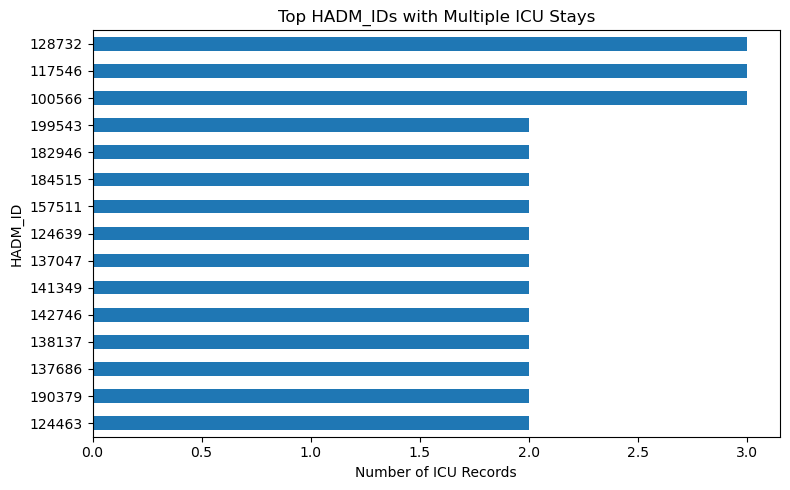

In [24]:
import matplotlib.pyplot as plt

repeated_hadm.head(15).sort_values().plot(kind='barh', figsize=(8, 5))
plt.title("Top HADM_IDs with Multiple ICU Stays")
plt.xlabel("Number of ICU Records")
plt.ylabel("HADM_ID")
plt.tight_layout()
plt.show()


In [25]:
repeated_hadm = repeated_hadm[repeated_hadm > 1].index.tolist()

repeated_rows = adm_icu_stays[adm_icu_stays['HADM_ID'].isin(repeated_hadm)]

In [26]:
repeated_rows_sorted = repeated_rows.sort_values(by=['HADM_ID', 'ICUSTAY_ID', 'INTIME'])
repeated_rows_sorted  # or display more as needed

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,...,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS_ICU_DAYS,SEQ_NUM,ICD9_CODE,SHORT_TITLE,LONG_TITLE
375515,30340,100563,2145-01-24 13:10:00,2145-02-23 10:29:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,...,SICU,57,57,2145-01-31 01:46:05,2145-02-08 17:59:04,8.675683,1.0,80609,C5-c7 fx-cl/cord inj NEC,Closed fracture of C5-C7 level with other spec...
375501,30340,100563,2145-01-24 13:10:00,2145-02-23 10:29:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,...,TSICU,14,14,2145-01-24 13:12:53,2145-01-25 20:43:00,1.312581,1.0,80609,C5-c7 fx-cl/cord inj NEC,Closed fracture of C5-C7 level with other spec...
264392,22067,100566,2128-01-17 16:35:00,2128-02-06 18:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,ENGL,...,TSICU,14,14,2128-02-01 00:59:21,2128-02-05 16:26:52,4.644109,1.0,80603,C1-c4 fx-cl/cen cord syn,Closed fracture of C1-C4 level with central co...
264379,22067,100566,2128-01-17 16:35:00,2128-02-06 18:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,ENGL,...,TSICU,14,14,2128-01-22 17:46:52,2128-01-28 15:49:29,5.918484,1.0,80603,C1-c4 fx-cl/cen cord syn,Closed fracture of C1-C4 level with central co...
264366,22067,100566,2128-01-17 16:35:00,2128-02-06 18:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,ENGL,...,TSICU,14,14,2128-01-17 16:40:28,2128-01-18 13:56:31,0.886146,1.0,80603,C1-c4 fx-cl/cen cord syn,Closed fracture of C1-C4 level with central co...
268942,22485,108241,2107-01-14 11:05:00,2107-01-24 12:24:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicaid,NaN,...,TSICU,14,14,2107-01-14 11:06:26,2107-01-18 17:19:30,4.259074,1.0,80600,C1-c4 fx-cl/cord inj NOS,Closed fracture of C1-C4 level with unspecifie...
268951,22485,108241,2107-01-14 11:05:00,2107-01-24 12:24:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicaid,NaN,...,TSICU,14,14,2107-01-14 11:06:26,2107-01-18 17:19:30,4.259074,10.0,80605,C5-c7 fx-cl/cord inj NOS,Closed fracture of C5-C7 level with unspecifie...
351502,28744,108474,2120-09-17 02:05:00,2120-12-05 11:56:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,...,TSICU,14,14,2120-09-17 02:06:10,2120-10-16 18:32:55,29.685243,1.0,80603,C1-c4 fx-cl/cen cord syn,Closed fracture of C1-C4 level with central co...
351517,28744,108474,2120-09-17 02:05:00,2120-12-05 11:56:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,...,TSICU,14,14,2120-09-17 02:06:10,2120-10-16 18:32:55,29.685243,16.0,80608,C5-c7 fx-cl/cen cord syn,Closed fracture of C5-C7 level with central co...
491371,56130,114902,2194-09-22 17:07:00,2194-10-08 12:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,LONG TERM CARE HOSPITAL,Private,ENGL,...,TSICU,14,14,2194-09-22 17:07:42,2194-10-08 12:43:11,15.816308,1.0,80604,C1-c4 fx-cl/cord inj NEC,Closed fracture of C1-C4 level with other spec...


In [27]:
# ICU LOS Aggregation Per Hospital Stay
# -------------------------------
print("Rows before aggregation:", adm_icu_stays.shape[0])

adm_icu_stays = adm_icu_stays.groupby(["SUBJECT_ID", "HADM_ID"], as_index=False).agg({
    'ADMITTIME': 'last',
    'DISCHTIME': 'last',
    'DEATHTIME': 'last',
    'ADMISSION_TYPE': 'last',
    'ADMISSION_LOCATION': 'last',
    'DISCHARGE_LOCATION': 'last',
    'INSURANCE': 'last',
    'LANGUAGE': 'last',
    'RELIGION': 'last',
    'MARITAL_STATUS': 'last',
    'ETHNICITY': 'last',
    'EDREGTIME': 'last',
    'EDOUTTIME': 'last',
    'DIAGNOSIS': 'last',
    'HOSPITAL_EXPIRE_FLAG': 'last',
    'HAS_CHARTEVENTS_DATA': 'last',
    'LOS_ADM_DAYS': 'last',
    'ICUSTAY_ID': 'last',
    'DBSOURCE': 'last',
    'FIRST_CAREUNIT': 'last',
    'LAST_CAREUNIT': 'last',
    'FIRST_WARDID': 'last',
    'LAST_WARDID': 'last',
    'INTIME': 'last',
    'OUTTIME': 'last',
    'LOS_ICU_DAYS': 'sum',  # Sum of ICU time across stays
    'ICD9_CODE': 'last',
    'LONG_TITLE': 'last'
})

adm_icu_stays['LOS_ICU_DAYS'] = round(adm_icu_stays['LOS_ICU_DAYS'], 8)
print("Rows after aggregation:", adm_icu_stays.shape[0])

Rows before aggregation: 179
Rows after aggregation: 154


<h4>SECTION: Data Cleansing </h4>

In [28]:
print(adm_icu_stays['MARITAL_STATUS'].value_counts())

MARITAL_STATUS
MARRIED              63
SINGLE               48
WIDOWED              11
DIVORCED              6
SEPARATED             1
UNKNOWN (DEFAULT)     1
LIFE PARTNER          1
Name: count, dtype: int64


In [29]:
missing_count = adm_icu_stays['MARITAL_STATUS'].isna().sum()
print("Missing (NaN) values in MARITAL_STATUS:", missing_count)

Missing (NaN) values in MARITAL_STATUS: 23


In [30]:
print(adm_icu_stays['ADMISSION_LOCATION'].value_counts())

ADMISSION_LOCATION
EMERGENCY ROOM ADMIT         117
CLINIC REFERRAL/PREMATURE     31
TRANSFER FROM HOSP/EXTRAM      3
PHYS REFERRAL/NORMAL DELI      2
TRANSFER FROM SKILLED NUR      1
Name: count, dtype: int64


In [31]:
missing_count3 = adm_icu_stays['DISCHARGE_LOCATION'].isna().sum()
print("Missing (NaN) values in DISCHARGE_LOCATION:", missing_count3)

Missing (NaN) values in DISCHARGE_LOCATION: 0


In [32]:
# # ADMISSION_TYPE
# adm_icu_stays['ADMISSION_TYPE'].replace('URGENT', 'EMERGENCY', inplace=True)

# # DISCHARGE_LOCATION
# adm_icu_stays['DISCHARGE_LOCATION'].replace({
#     'HOME WITH HOME IV PROVIDR': 'HOME HEALTH CARE',
#     'SNF': 'SKILLED NURSING FACILITY',
#     'LEFT AGAINST MEDICAL ADVI': 'HOME',
#     'ICF': 'INTERMEDIATE CARE FACILITY'
# }, inplace=True)
# adm_icu_stays = adm_icu_stays[adm_icu_stays['DISCHARGE_LOCATION'] != 'OTHER FACILITY']

In [33]:
# ETHNICITY Standardization
adm_icu_stays['ETHNICITY'].replace([
    'UNKNOWN/NOT SPECIFIED', 'UNABLE TO OBTAIN', 'OTHER', 'PATIENT DECLINED TO ANSWER'
], 'UNSPECIFIED', inplace=True)

adm_icu_stays['ETHNICITY'].replace({
    'ASIAN - ASIAN INDIAN': 'ASIAN',
    'ASIAN - FILIPINO': 'ASIAN',
    'ASIAN - CHINESE': 'ASIAN',
    'BLACK/AFRICAN AMERICAN': 'BLACK',
    'BLACK/AFRICAN': 'BLACK',
    'BLACK/CAPE VERDEAN': 'BLACK',
    'BLACK/HAITIAN': 'BLACK',
    'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)': 'HISPANIC',
    'HISPANIC/LATINO - CENTRAL AMERICAN ()': 'HISPANIC',
    'HISPANIC/LATINO - CENTRAL AMERICAN (UNSPECIFIED)': 'HISPANIC',
    'HISPANIC OR LATINO': 'HISPANIC',
    'HISPANIC/LATINO - DOMINICAN': 'HISPANIC',
    'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC',
    'WHITE -  EUROPEAN': 'WHITE',
    'WHITE - BRAZILIAN': 'WHITE',
    'WHITE - OTHER EUROPEAN': 'WHITE',
    'WHITE - UNSPECIFIED EUROPEAN': 'WHITE'
}, inplace=True)

In [34]:
adm_icu_stays['LOS_ICU_DAYS'].sort_values()

22      0.334722
19      0.347755
132     0.799595
16      0.826100
90      0.938229
         ...    
36     37.795023
37     41.968912
20     54.175000
91     59.370486
123    63.372986
Name: LOS_ICU_DAYS, Length: 154, dtype: float64

In [35]:
adm_icu_stays.shape[0]

154

In [36]:
adm_icu_stays['EDREGTIME'] = pd.to_datetime(adm_icu_stays['EDREGTIME'], errors='coerce')
adm_icu_stays['EDOUTTIME'] = pd.to_datetime(adm_icu_stays['EDOUTTIME'], errors='coerce')


In [37]:
adm_icu_stays['ED_DURATION'] = (adm_icu_stays['EDOUTTIME'] - adm_icu_stays['EDREGTIME']).dt.total_seconds() / 3600


In [38]:
adm_icu_stays['ED_DURATION'] = adm_icu_stays['ED_DURATION'].fillna(0)

In [39]:
adm_icu_stays.drop(columns=['EDREGTIME', 'EDOUTTIME'], inplace=True)

In [40]:
adm_icu_stays['LOS_ICU_DAYS'].value_counts().sort_index()


LOS_ICU_DAYS
0.334722     1
0.347755     1
0.799595     1
0.826100     1
0.938229     1
            ..
37.795023    1
41.968912    1
54.175000    1
59.370486    1
63.372986    1
Name: count, Length: 154, dtype: int64

<h3>Univariate Distribution Plots (Continuous Variables)</h3>

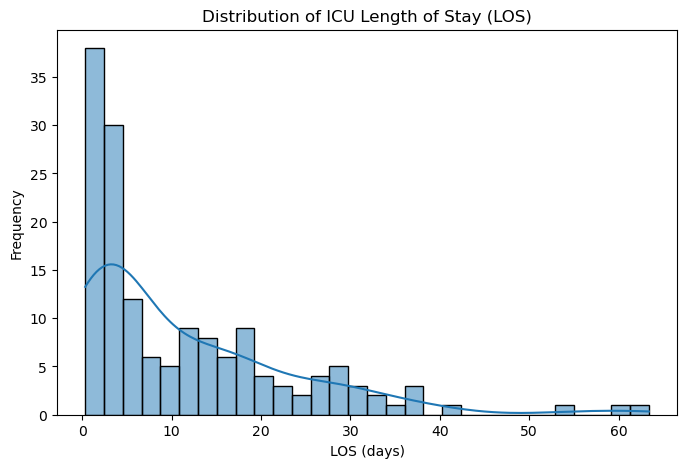

In [41]:
# Plot distribution of ICU Length of Stay
plt.figure(figsize=(8, 5))
sns.histplot(data=adm_icu_stays, x='LOS_ICU_DAYS', kde=True, bins=30)
plt.title('Distribution of ICU Length of Stay (LOS)')
plt.xlabel('LOS (days)')
plt.ylabel('Frequency')
plt.show()

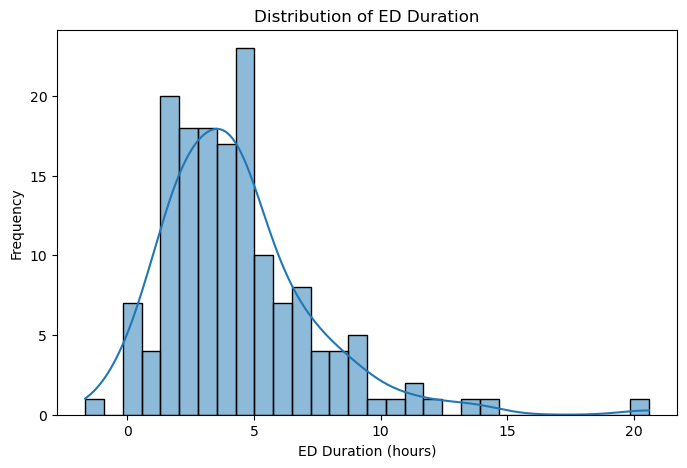

In [42]:
plt.figure(figsize=(8, 5))
sns.histplot(data=adm_icu_stays, x='ED_DURATION', kde=True, bins=30)
plt.title('Distribution of ED Duration')
plt.xlabel('ED Duration (hours)')
plt.ylabel('Frequency')
plt.show()


<h3>Univariate Frequency Plots (Categorical Variables)</h3>

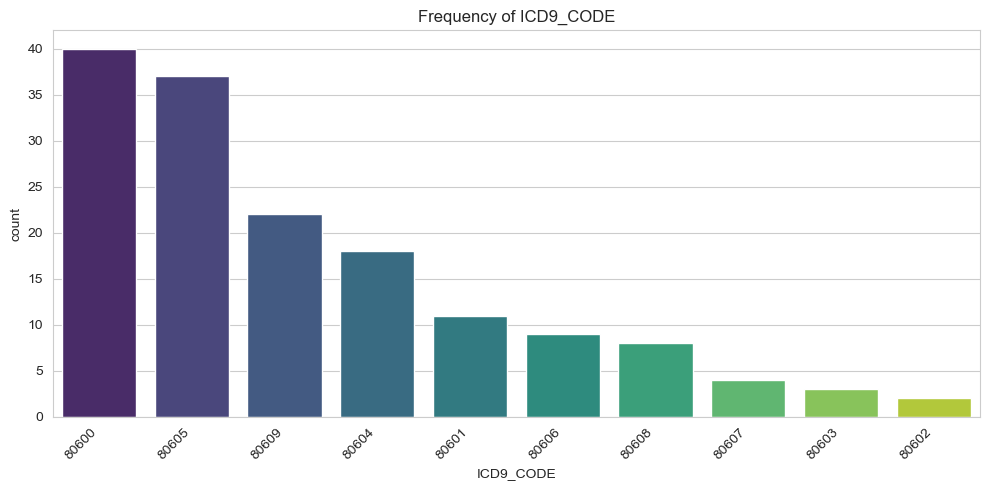

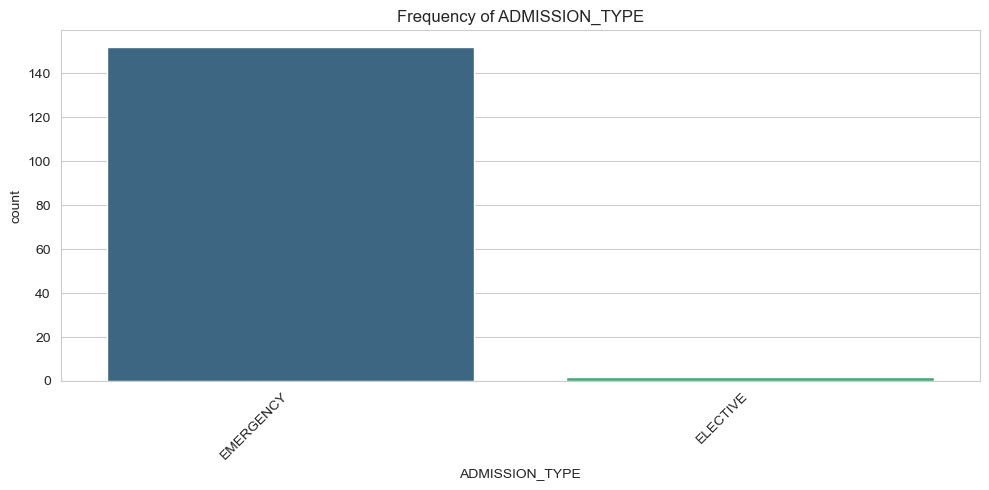

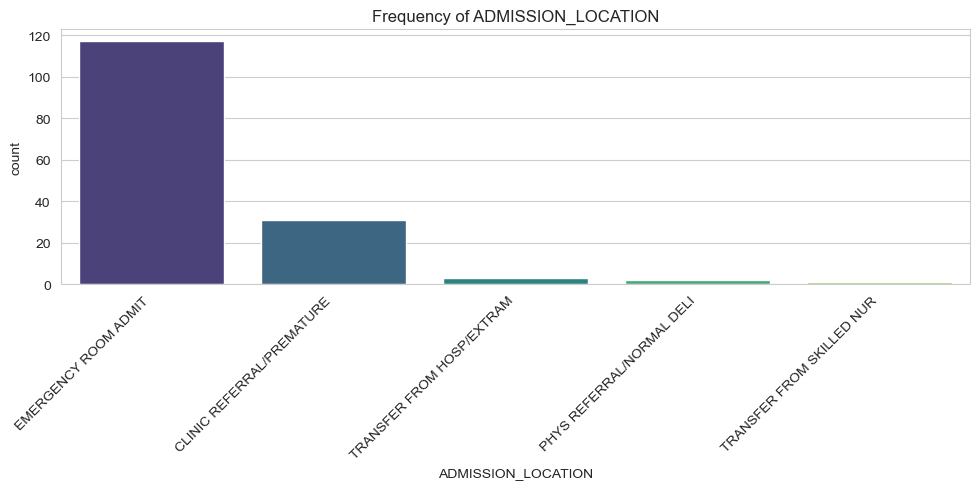

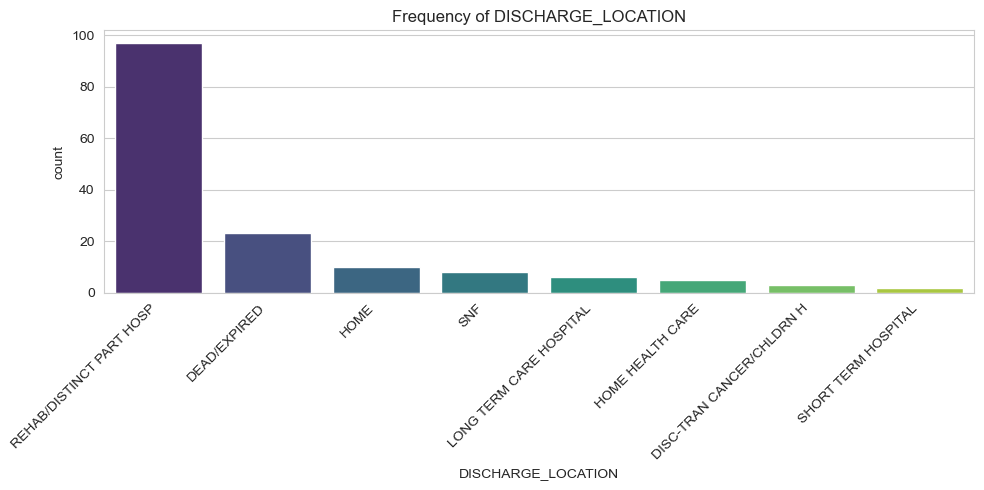

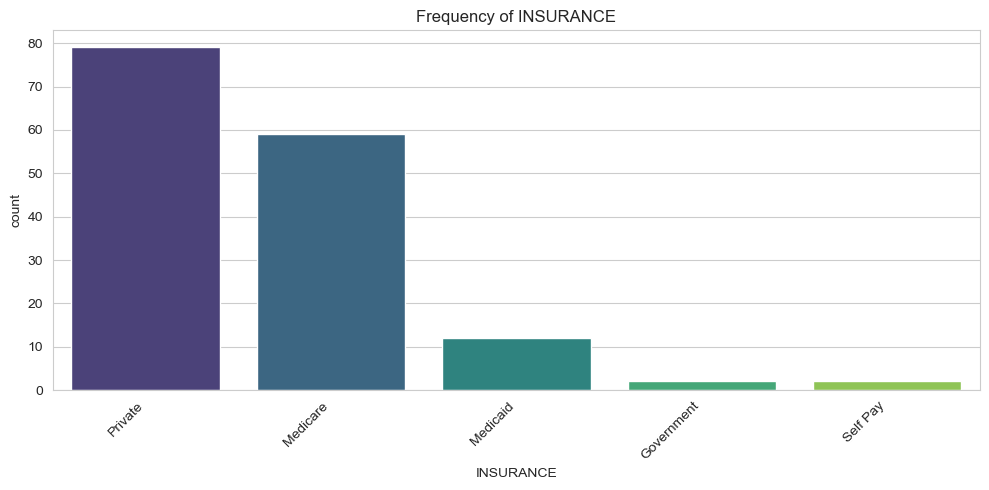

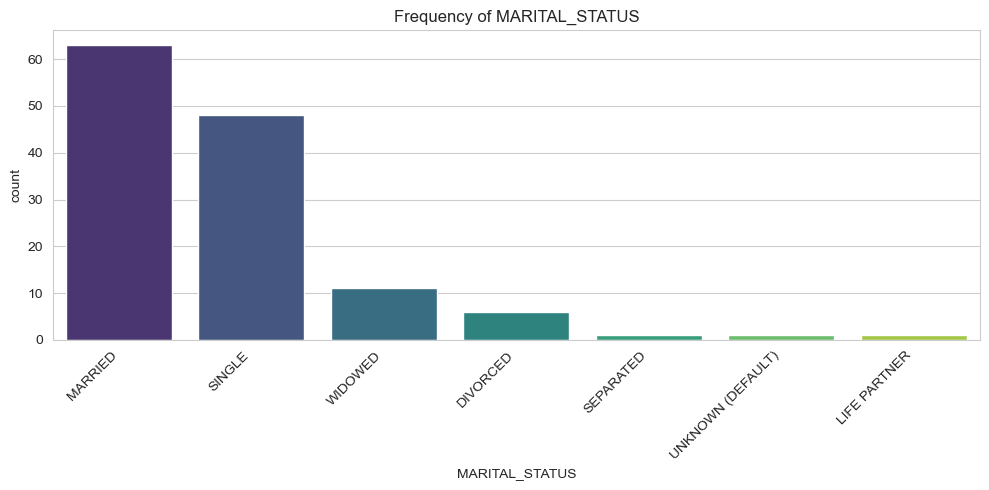

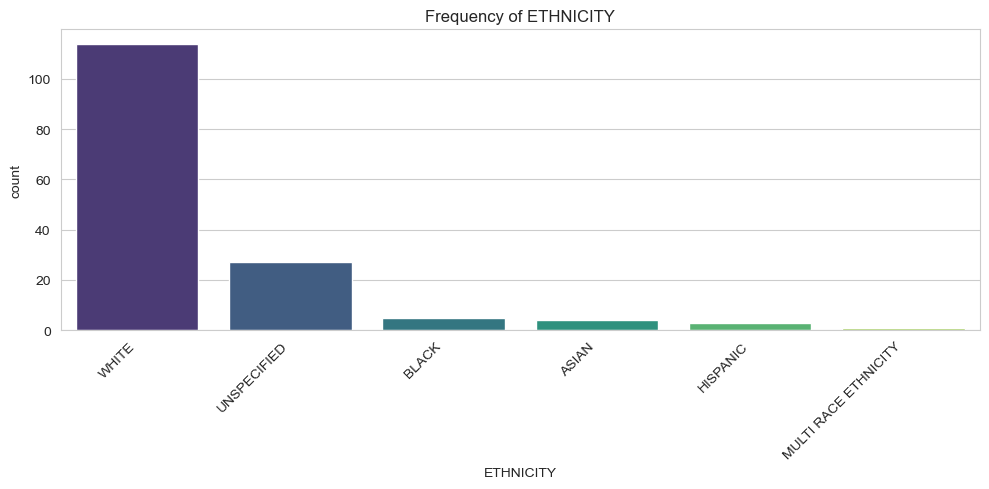

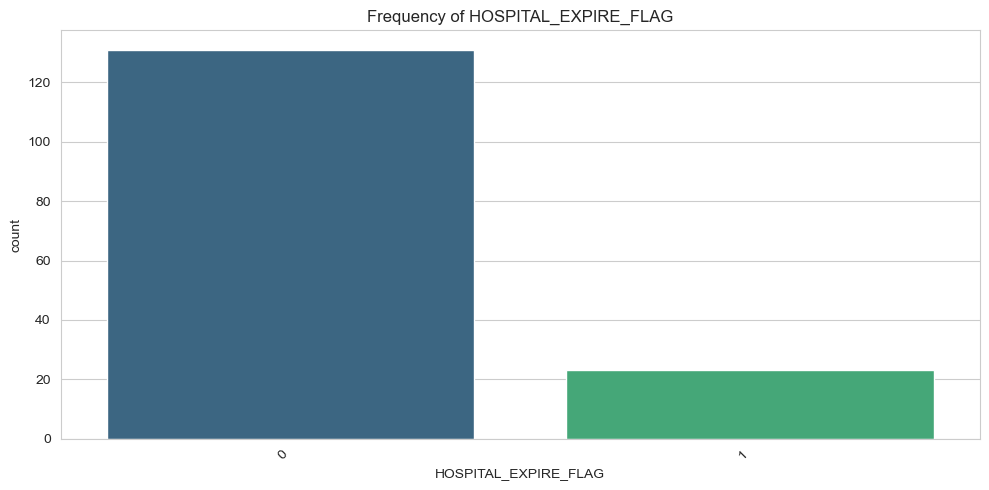

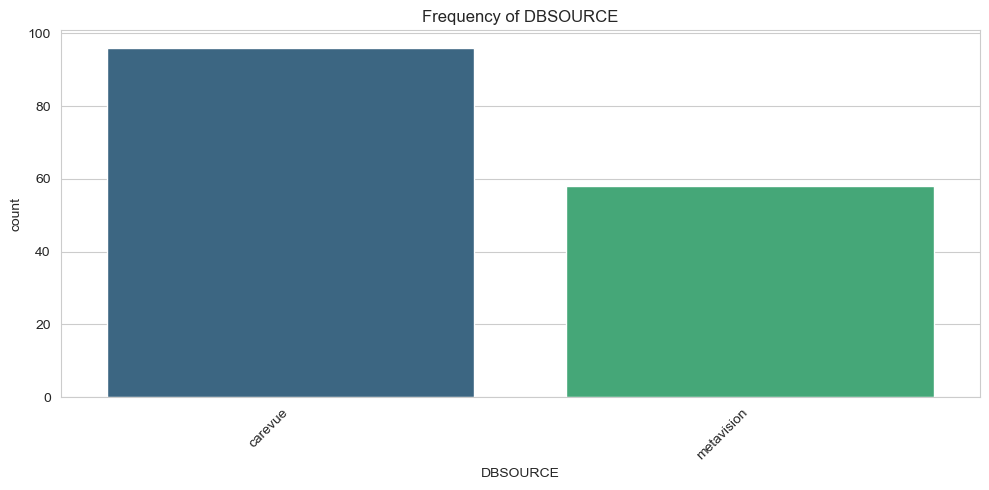

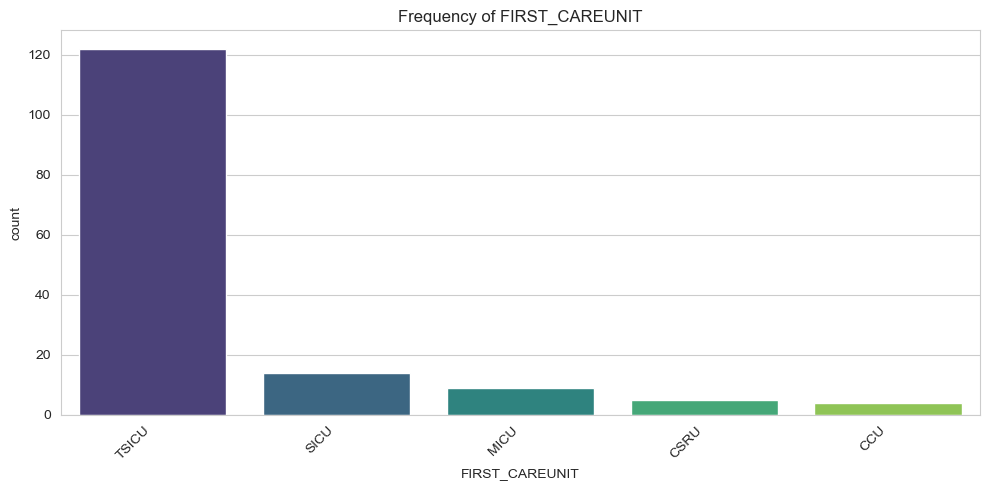

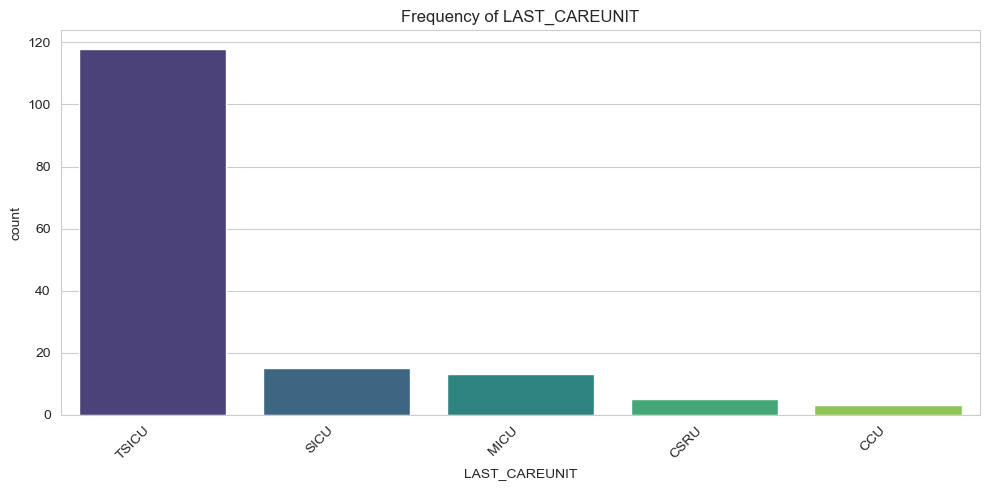

In [43]:
sns.set_style('whitegrid')

# List of categorical variables
categorical_vars = [
    'ICD9_CODE', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
    'DISCHARGE_LOCATION', 'INSURANCE', 'MARITAL_STATUS', 'ETHNICITY', 'HOSPITAL_EXPIRE_FLAG', 'DBSOURCE', 'FIRST_CAREUNIT', 'LAST_CAREUNIT'
]

import math

# Loop through each categorical column and plot bar charts
for col in categorical_vars:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=adm_icu_stays, x=col, order=adm_icu_stays[col].value_counts().index,  palette='viridis')
    plt.title(f'Frequency of {col}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


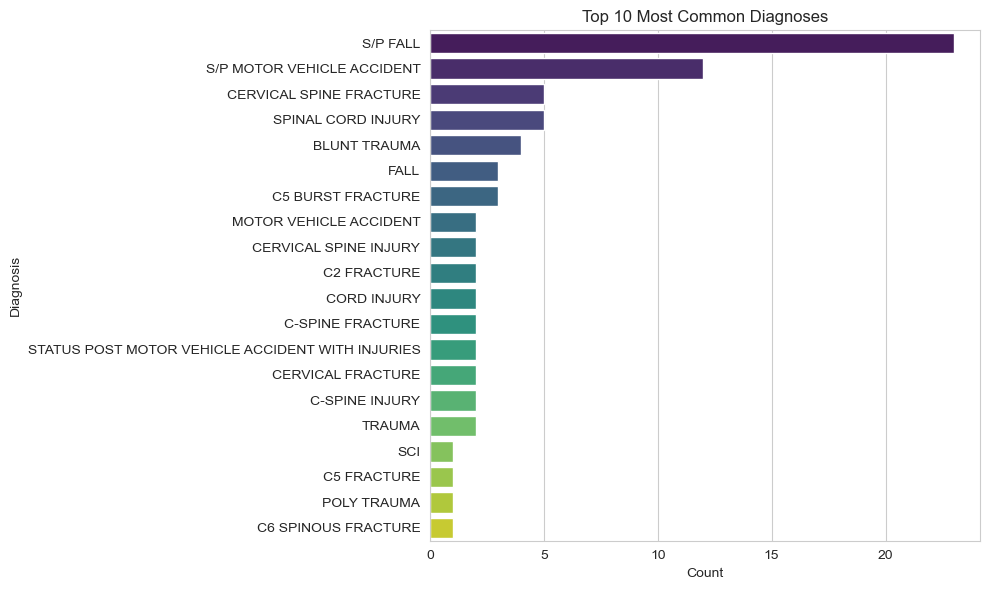

In [44]:
# Count frequency of each diagnosis
top_diagnoses = adm_icu_stays['DIAGNOSIS'].value_counts().head(20)

# Plot the top 10
plt.figure(figsize=(10, 6))
sns.barplot(x=top_diagnoses.values, y=top_diagnoses.index, palette='viridis')
plt.title('Top 10 Most Common Diagnoses')
plt.xlabel('Count')
plt.ylabel('Diagnosis')
plt.tight_layout()
plt.show()


<h3>LOS vs all other variables</h3>

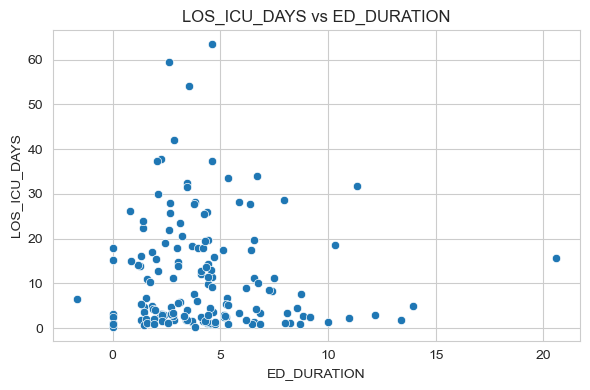

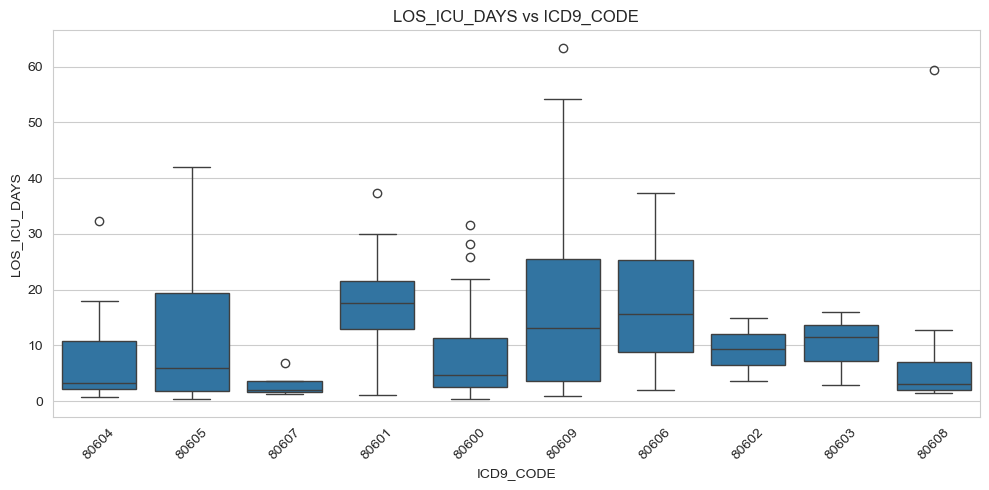

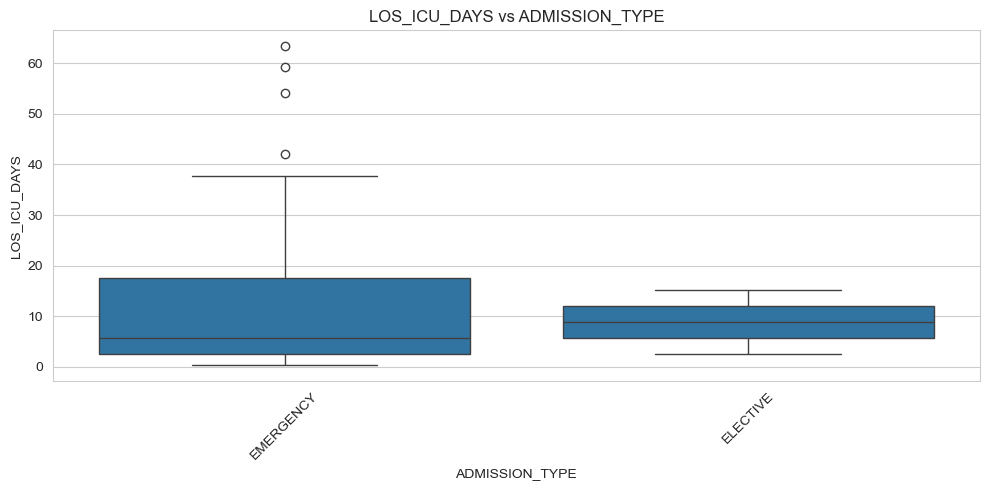

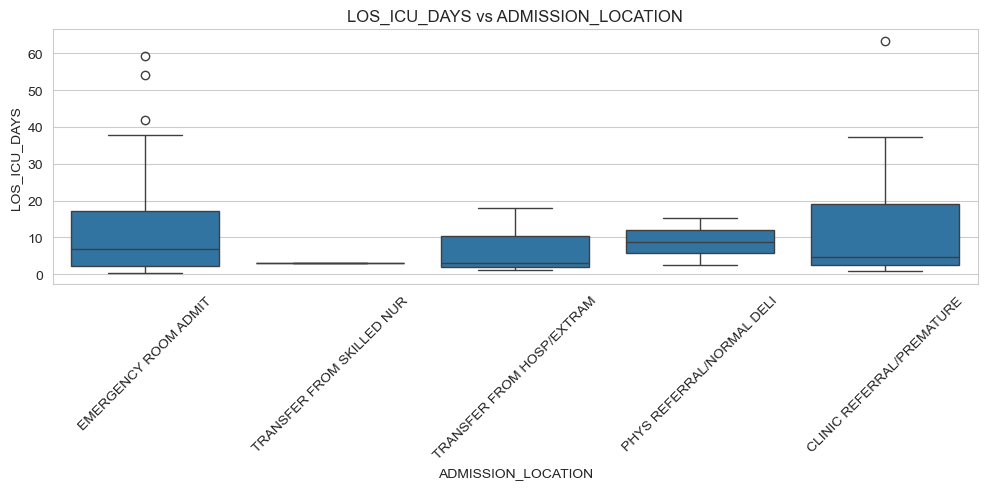

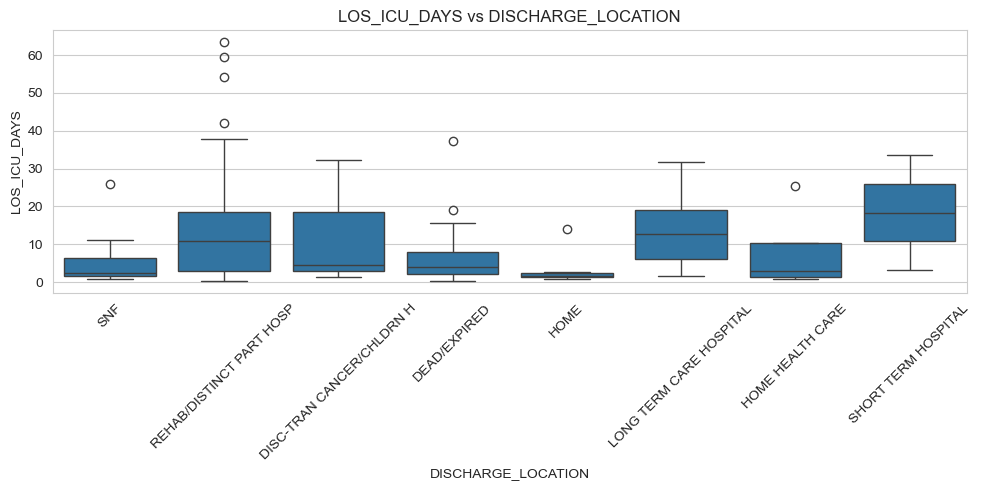

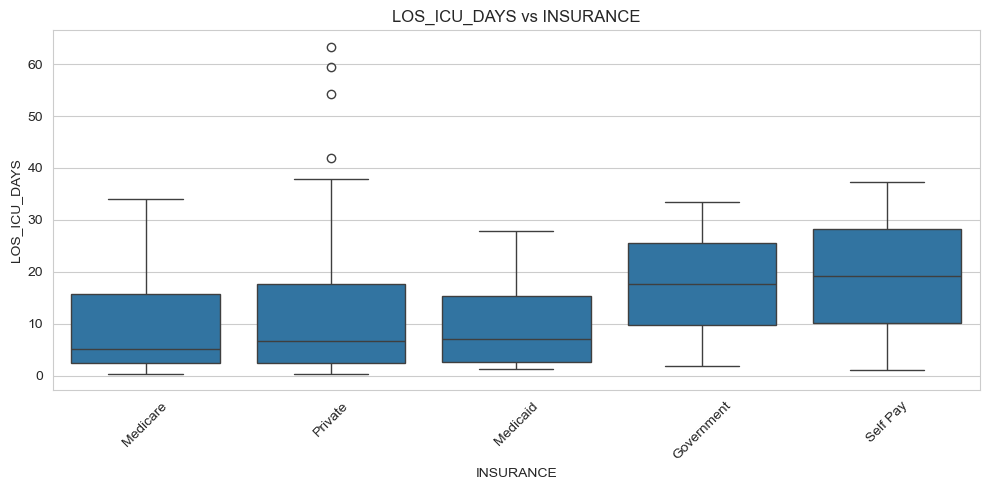

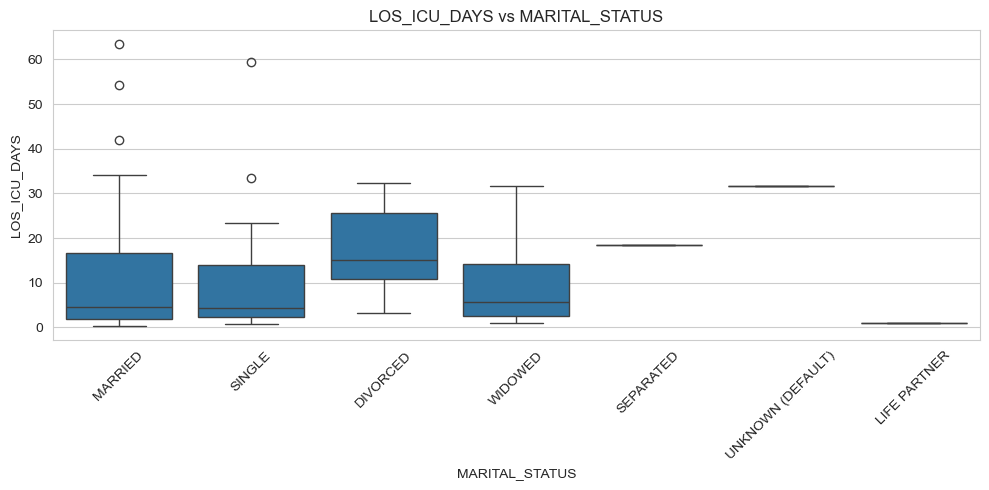

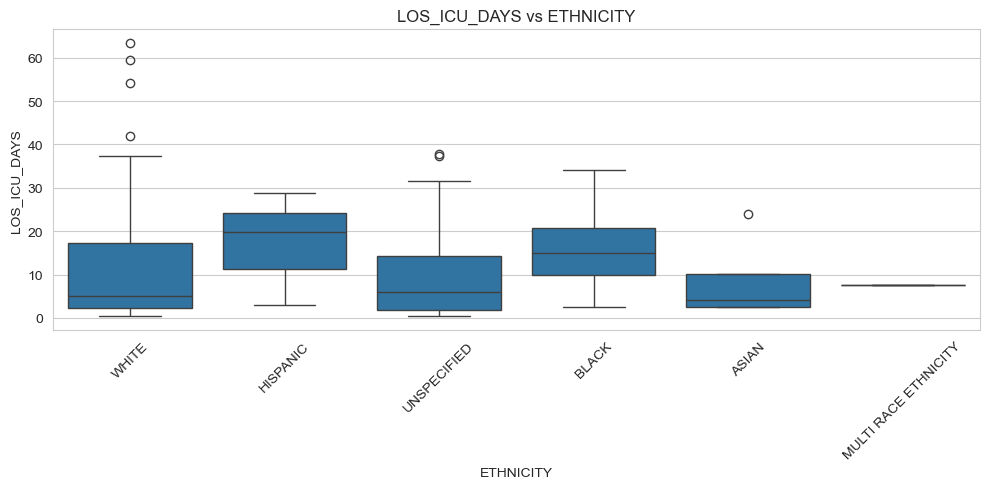

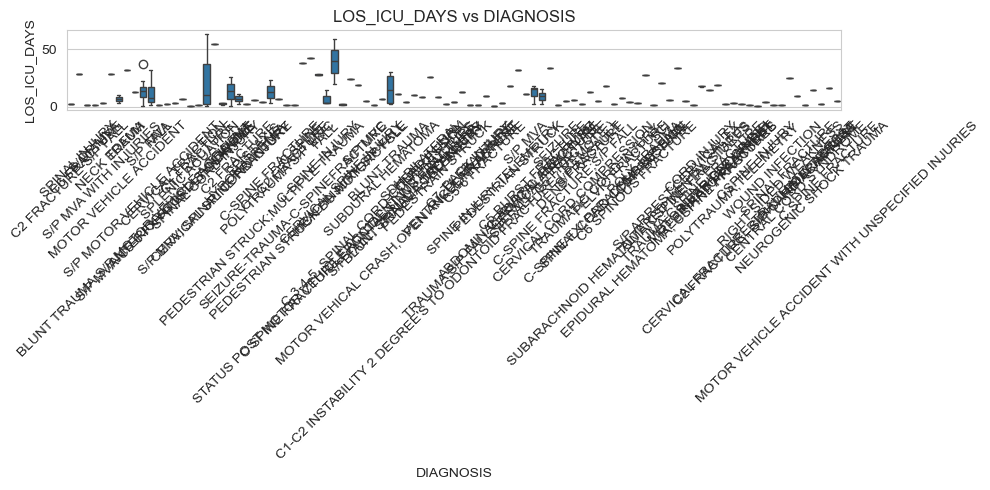

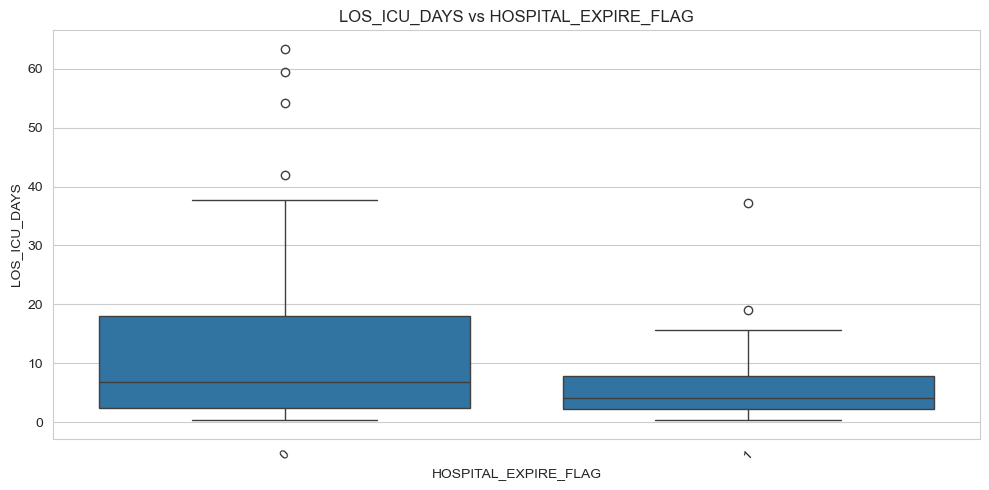

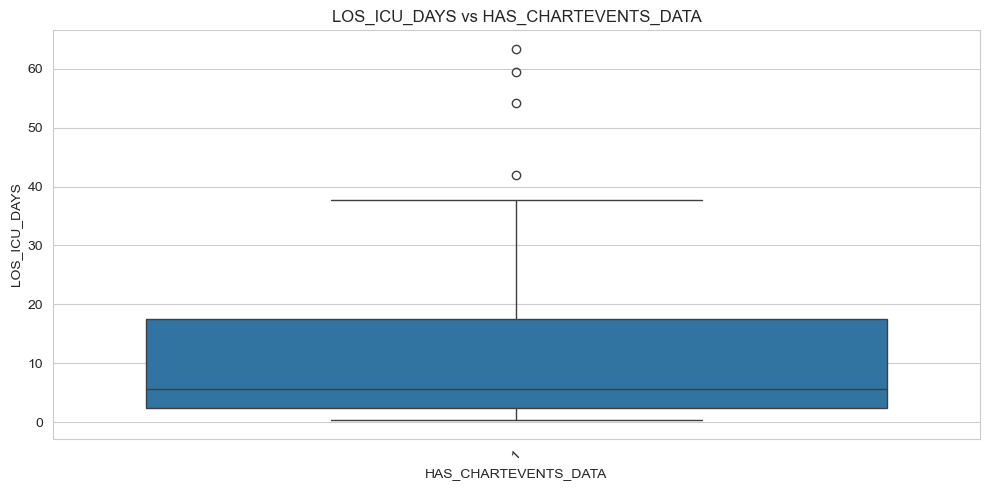

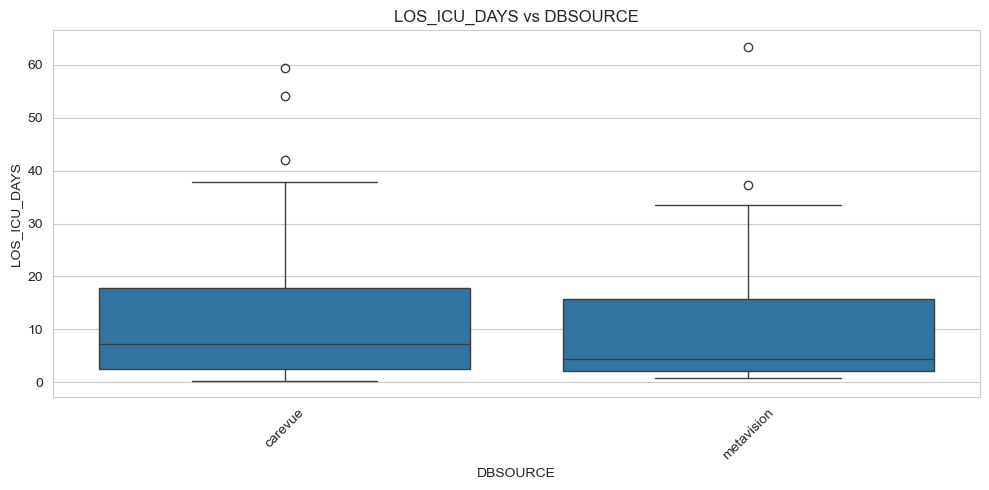

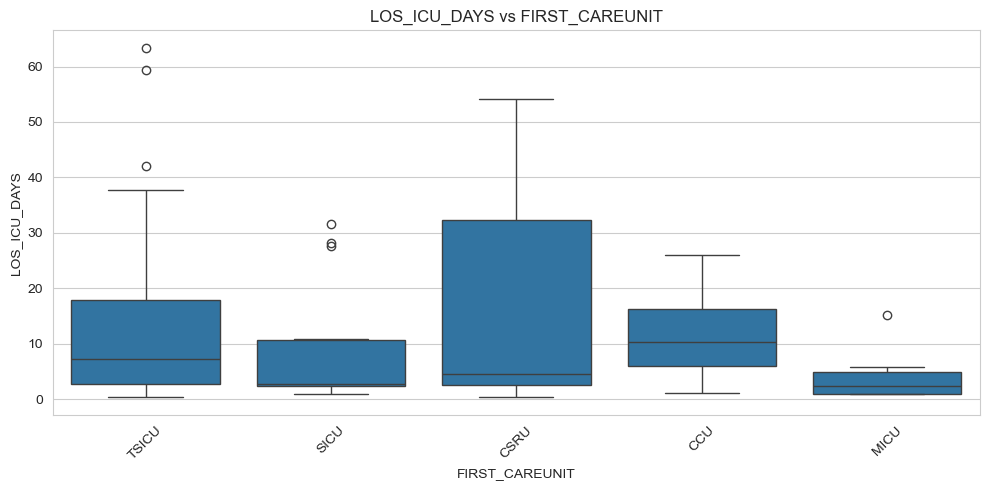

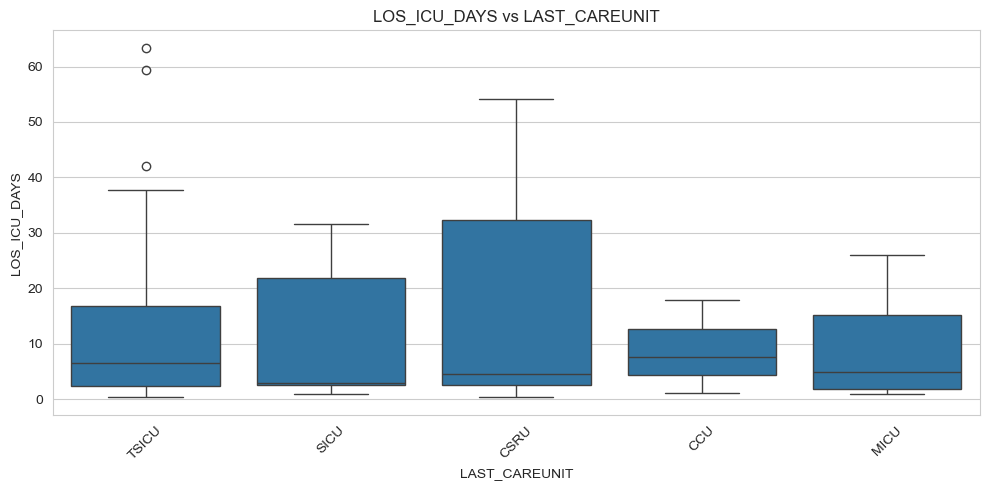

In [45]:
# Define your continuous and categorical variables (based on your latest columns)
continuous_vars = ['ED_DURATION']
categorical_vars = ['ICD9_CODE', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
                    'DISCHARGE_LOCATION', 'INSURANCE', 'MARITAL_STATUS', 'ETHNICITY',
                    'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA',
                    'DBSOURCE', 'FIRST_CAREUNIT', 'LAST_CAREUNIT']

# Continuous vs LOS (scatterplots)
for var in continuous_vars:
    if var in adm_icu_stays.columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=adm_icu_stays, x=var, y='LOS_ICU_DAYS')
        plt.title(f'LOS_ICU_DAYS vs {var}')
        plt.xlabel(var)
        plt.ylabel('LOS_ICU_DAYS')
        plt.tight_layout()
        plt.show()

# Categorical vs LOS (boxplots)
for var in categorical_vars:
    if var in adm_icu_stays.columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(data=adm_icu_stays, x=var, y='LOS_ICU_DAYS')
        plt.title(f'LOS_ICU_DAYS vs {var}')
        plt.xlabel(var)
        plt.ylabel('LOS_ICU_DAYS')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


<h3>Group by diagnosis and plot average LOS</h3>

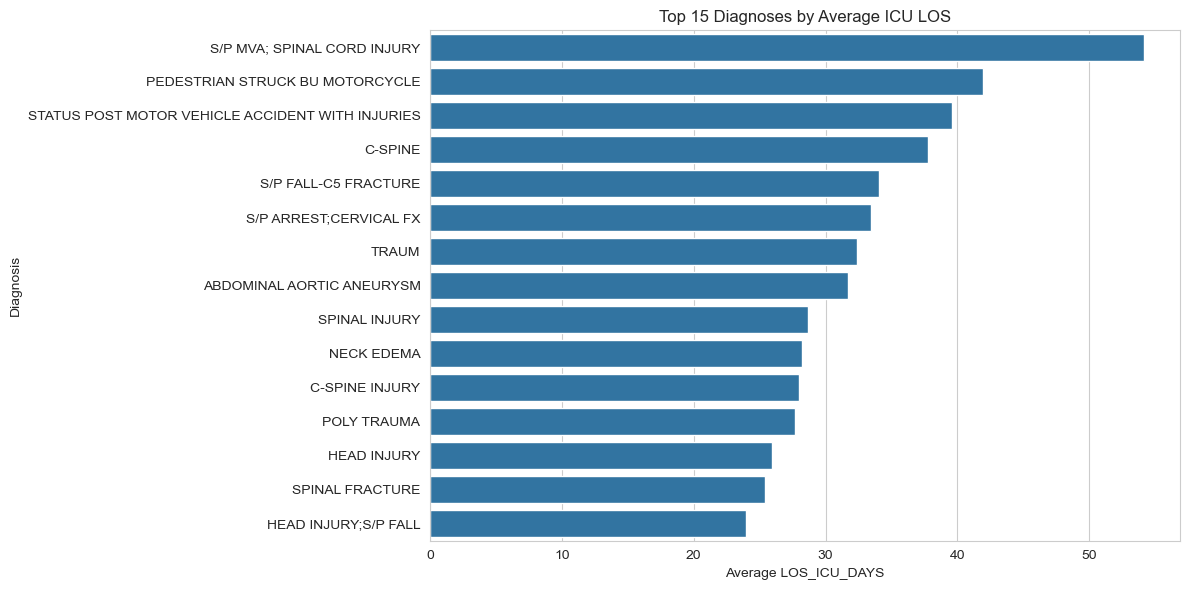

In [46]:
# Group and get average LOS
mean_los_by_diag = adm_icu_stays.groupby('DIAGNOSIS')['LOS_ICU_DAYS'].mean().sort_values(ascending=False).head(15)

# Barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=mean_los_by_diag.values, y=mean_los_by_diag.index)
plt.title('Top 15 Diagnoses by Average ICU LOS')
plt.xlabel('Average LOS_ICU_DAYS')
plt.ylabel('Diagnosis')
plt.tight_layout()
plt.show()

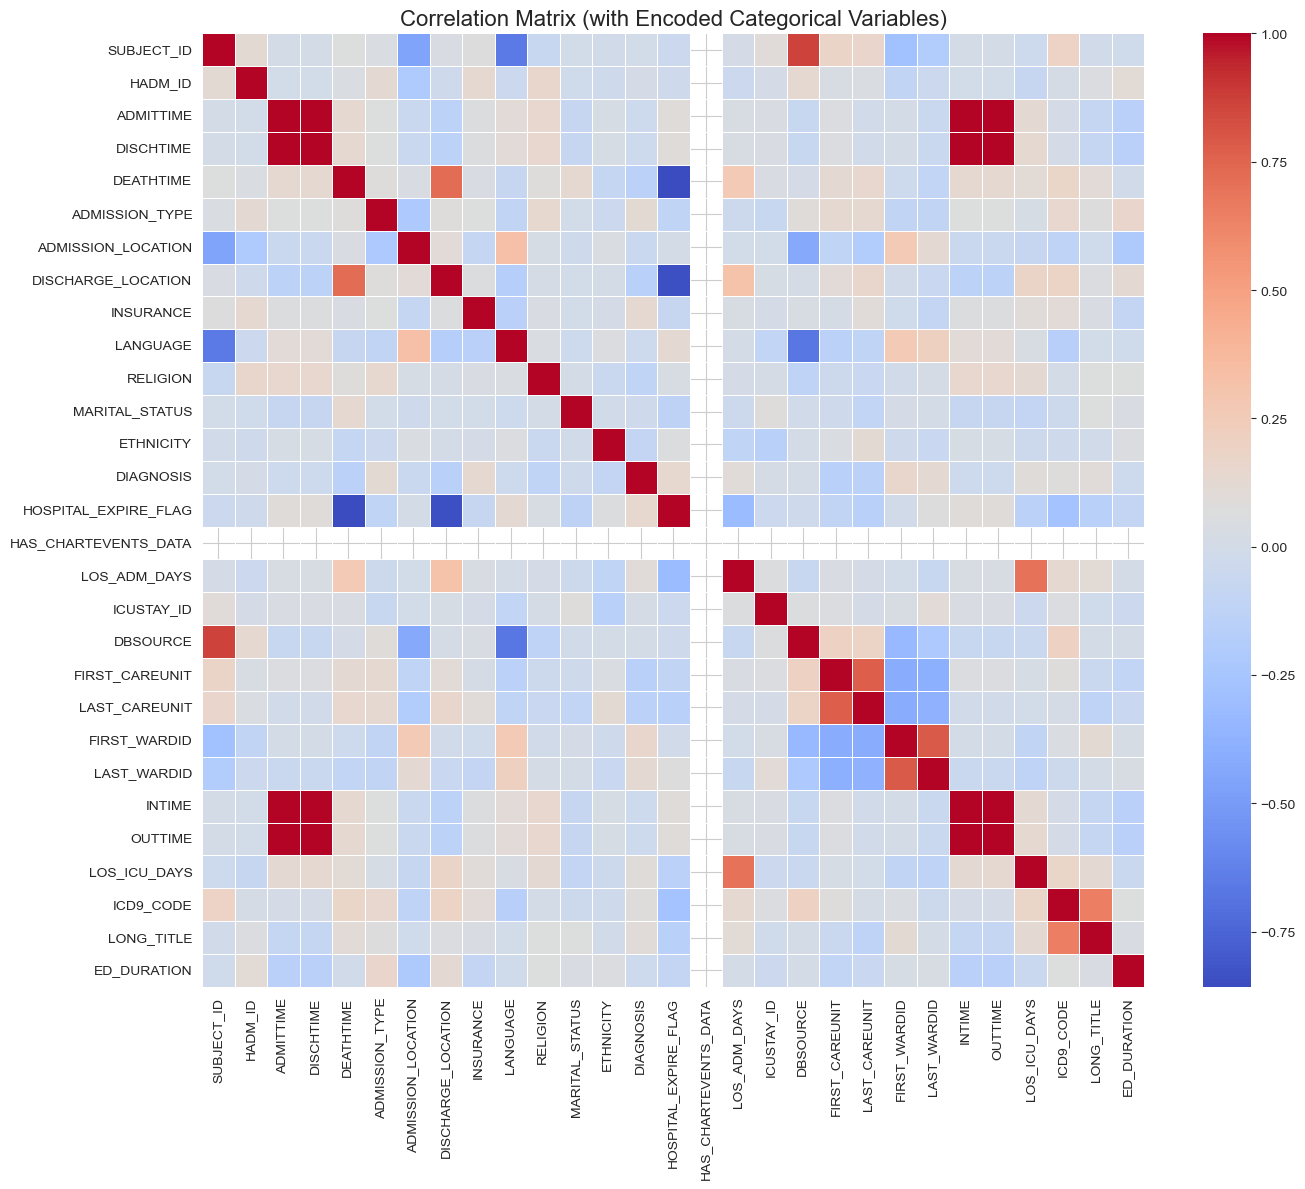

In [47]:
from sklearn.preprocessing import LabelEncoder

# Make a copy to avoid modifying original
df_encoded = adm_icu_stays.copy()

# Encode categorical columns
for col in df_encoded.select_dtypes(include=['object']).columns:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col].astype(str))

# Compute correlation matrix
corr_matrix = df_encoded.corr()

# Plot heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (with Encoded Categorical Variables)', fontsize=16)
plt.tight_layout()
plt.show()

<h3>Pie Chart – Admission Type Distribution</h3>

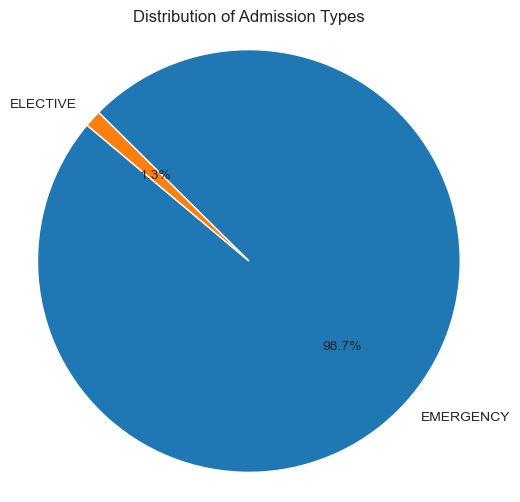

In [48]:
admission_counts = adm_icu_stays['ADMISSION_TYPE'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(admission_counts, labels=admission_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Admission Types')
plt.axis('equal')
plt.show()

<h3>Pie Chart – Survival Rate</h3>

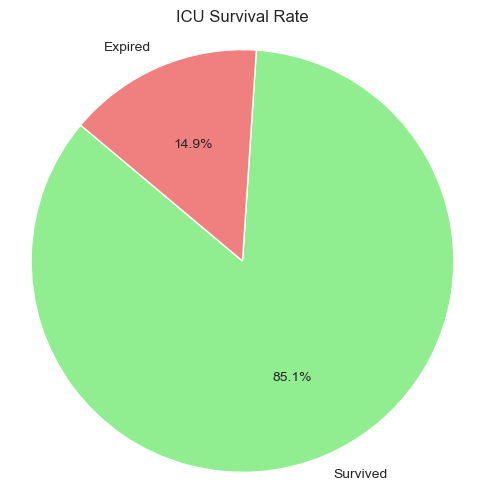

In [49]:
survival = adm_icu_stays['HOSPITAL_EXPIRE_FLAG'].value_counts()
labels = ['Survived', 'Expired']

plt.figure(figsize=(6, 6))
plt.pie(survival, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'lightcoral'])
plt.title('ICU Survival Rate')
plt.axis('equal')
plt.show()

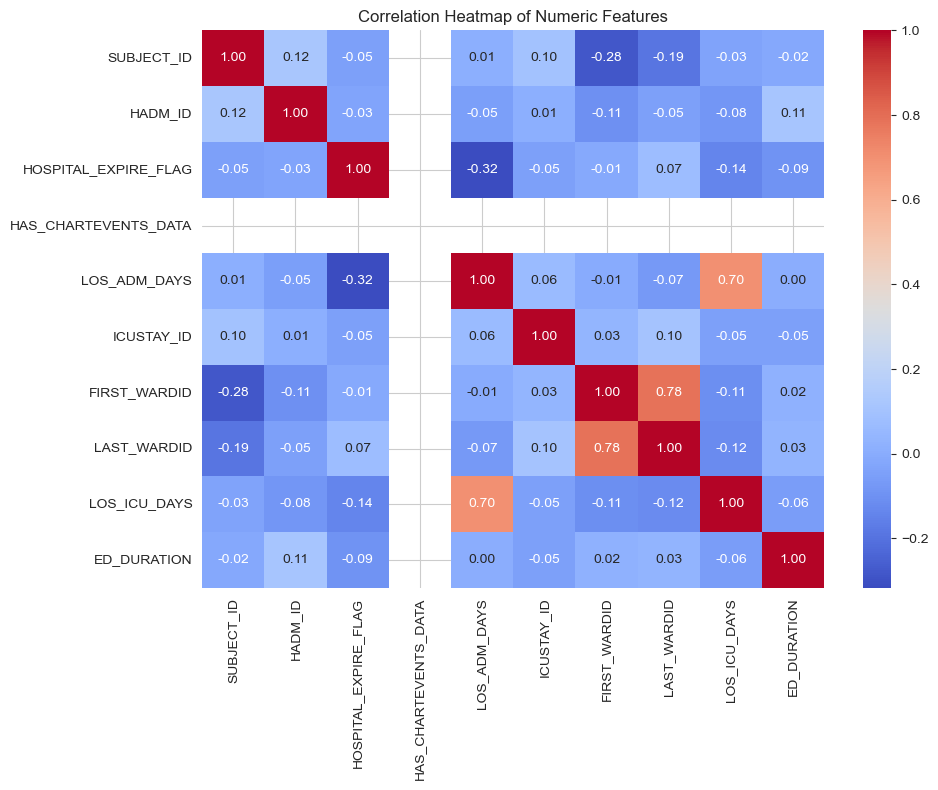

In [50]:
corr = adm_icu_stays.select_dtypes(include='number').corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.tight_layout()
plt.show()


<h3>SECTION: Modelling </h3>

<h3> Neural Network Model </h3>

In [51]:
!pip install tensorflow

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# scikit-learn libraries for splitting and scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# TensorFlow/Keras libraries for building the neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# -------------------------
# Data Preparation
# -------------------------

# Check if LOS_ICU_LOG exists; if not, create it using log1p transformation.
if 'LOS_ICU_LOG' not in adm_icu_stays.columns:
    adm_icu_stays['LOS_ICU_LOG'] = np.log1p(adm_icu_stays['LOS_ICU_DAYS'])

# Create a working copy for the neural network model.
data_nn = adm_icu_stays.copy()

# Dummy encode the INSURANCE variable (if it exists)
if 'INSURANCE' in data_nn.columns:
    data_nn = pd.get_dummies(data_nn, columns=['INSURANCE'], drop_first=True)

# Define feature columns.
# You can include LOS_ADM_DAYS (length of hospital stay) and the insurance dummies.
dummy_cols = [col for col in data_nn.columns if col.startswith('INSURANCE_')]
feature_cols = ['LOS_ADM_DAYS'] + dummy_cols

# Set the feature matrix X and target variable y.
X = data_nn[feature_cols]
y = data_nn['LOS_ICU_LOG']  # target: log-transformed ICU LOS

# Split the dataset into training and testing sets (80% train, 20% test).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Scale the feature variables (neural networks typically benefit from scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Training set shape:", X_train_scaled.shape)
print("Test set shape:", X_test_scaled.shape)


Training set shape: (123, 5)
Test set shape: (31, 5)


In [53]:
# -------------------------
# Build the Neural Network Model
# -------------------------

model = Sequential()

# Input layer: number of neurons equals the number of features; use 16 neurons in first hidden layer.
model.add(Dense(16, input_dim=X_train_scaled.shape[1], activation='relu'))

# Second hidden layer with 8 neurons.
model.add(Dense(8, activation='relu'))

# Output layer: 1 neuron with linear activation for regression output.
model.add(Dense(1, activation='linear'))

# Compile the model: using 'adam' optimizer, Mean Squared Error (MSE) loss, and Mean Absolute Error (MAE) metric.
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Display model summary.
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241 (964.00 B)

 Trainable params: 241 (964.00 B)

 Non-trainable params: 0 (0.00 B)

In [54]:
# -------------------------
# Train the Model
# -------------------------

# Define EarlyStopping to monitor validation loss, with a patience of 10 epochs.
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model on the training set. 20% of the training data is used for validation.
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

print("Training complete!")


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 5.9663 - mae: 2.1272 - val_loss: 4.4031 - val_mae: 1.8424
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.5544 - mae: 2.0481 - val_loss: 4.1703 - val_mae: 1.7867
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.2029 - mae: 1.9781 - val_loss: 3.9538 - val_mae: 1.7327
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8842 - mae: 1.9120 - val_loss: 3.7500 - val_mae: 1.6798
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.5899 - mae: 1.8481 - val_loss: 3.5587 - val_mae: 1.6279
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.3213 - mae: 1.7867 - val_loss: 3.3759 - val_mae: 1.5764
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.0826 - mae: 1.7283 - val_loss: 3.1969 - val_mae: 1.5242
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.8474 - mae: 1.6685 - val_loss: 3.0220 - val_mae: 1.4713
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 3.6208 - mae: 

In [55]:
# -------------------------
# Evaluate the Model
# -------------------------

# Evaluate the model on the scaled test set.
loss, mae = model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test MSE:", loss)
print("Test MAE:", mae)

# Predict on the test set. Predictions will be on the log-scale.
y_pred_log = model.predict(X_test_scaled)

# Back-transform predictions to the original LOS_ICU_DAYS scale using np.expm1 (the inverse of np.log1p)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

# Calculate evaluation metrics on the original scale.
mse_original = mean_squared_error(y_test_actual, y_pred)
mae_original = mean_absolute_error(y_test_actual, y_pred)
r2_original = r2_score(y_test_actual, y_pred)

print("Back-transformed Test MSE: {:.2f}".format(mse_original))
print("Back-transformed Test MAE: {:.2f}".format(mae_original))
print("Back-transformed Test R-squared: {:.2f}".format(r2_original))

# Display a comparison of the first 10 actual vs. predicted LOS_ICU_DAYS.
comparison_df = pd.DataFrame({
    'Actual LOS_ICU_DAYS': y_test_actual,
    'Predicted LOS_ICU_DAYS': y_pred.flatten()
})
print(comparison_df.head(10))


Test MSE: 0.7190862894058228
Test MAE: 0.7203879952430725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Back-transformed Test MSE: 140.32
Back-transformed Test MAE: 8.23
Back-transformed Test R-squared: -0.08
     Actual LOS_ICU_DAYS  Predicted LOS_ICU_DAYS
15              6.833588                6.024456
94              9.988264               12.046331
152             1.326551                8.661594
105             4.044201                3.018240
109            27.684664                7.575840
65              4.093299                4.722194
18              1.691887                5.064746
45             19.785220                7.120442
36             37.795023                6.709777
55             10.867604                8.691861


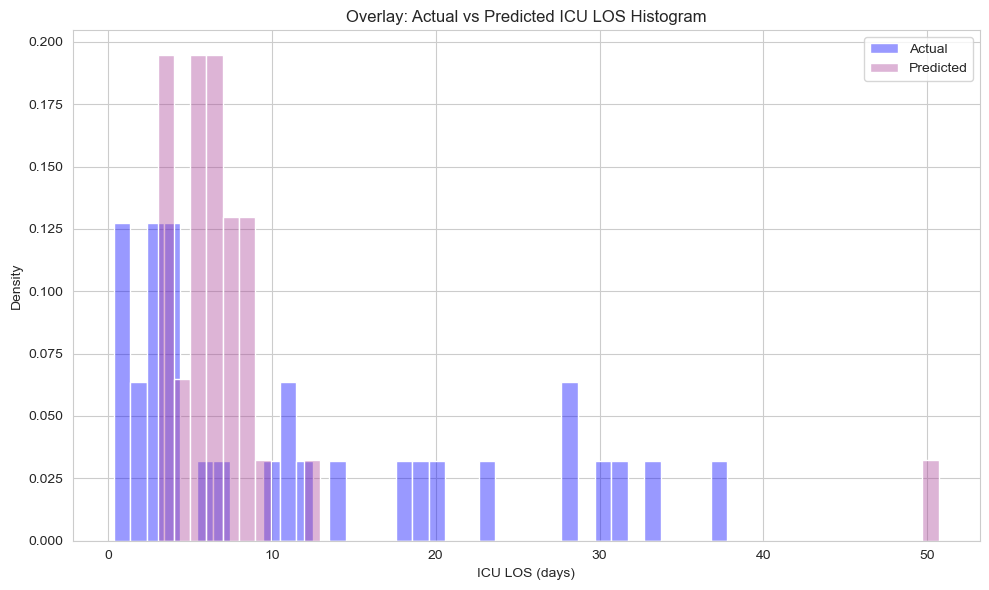

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Check that your df_comparison has the correct columns:
# print(df_comparison.head())

plt.figure(figsize=(10,6))
sns.histplot(comparison_df['Actual LOS_ICU_DAYS'], binwidth=1, stat='density', 
             color='blue', alpha=0.4, label='Actual')
sns.histplot(comparison_df['Predicted LOS_ICU_DAYS'], binwidth=1, stat='density', 
             color='#AA4499', alpha=0.4, label='Predicted')
plt.title("Overlay: Actual vs Predicted ICU LOS Histogram")
plt.xlabel("ICU LOS (days)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()



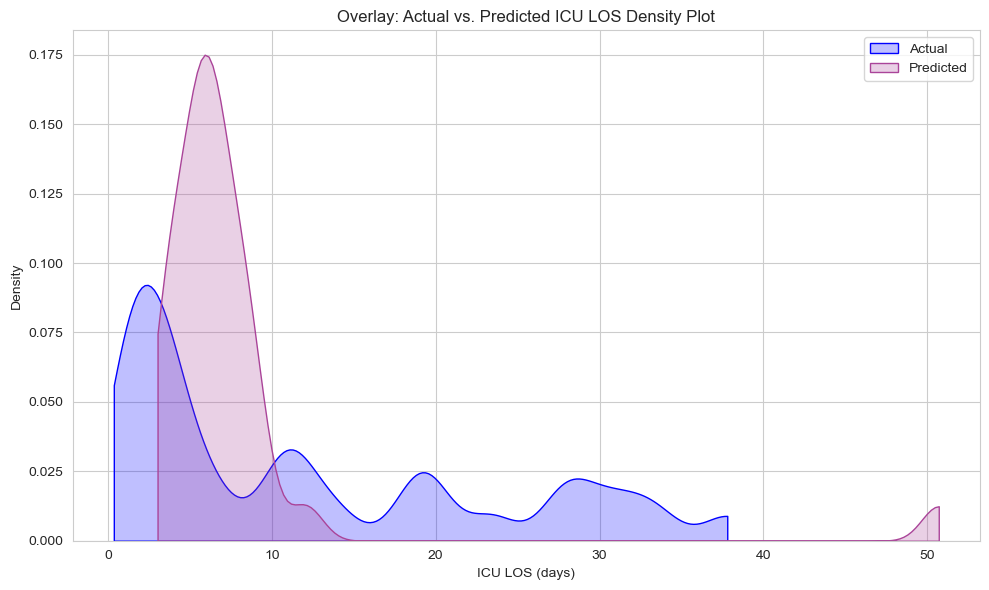

In [57]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=comparison_df, x='Actual LOS_ICU_DAYS', fill=True, color='blue', 
            cut=0, clip=(0, None), bw_adjust=0.25, label='Actual')
sns.kdeplot(data=comparison_df, x='Predicted LOS_ICU_DAYS', fill=True, color='#AA4499', 
            cut=0, clip=(0, None), bw_adjust=0.25, label='Predicted')
plt.title("Overlay: Actual vs. Predicted ICU LOS Density Plot")
plt.xlabel("ICU LOS (days)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()


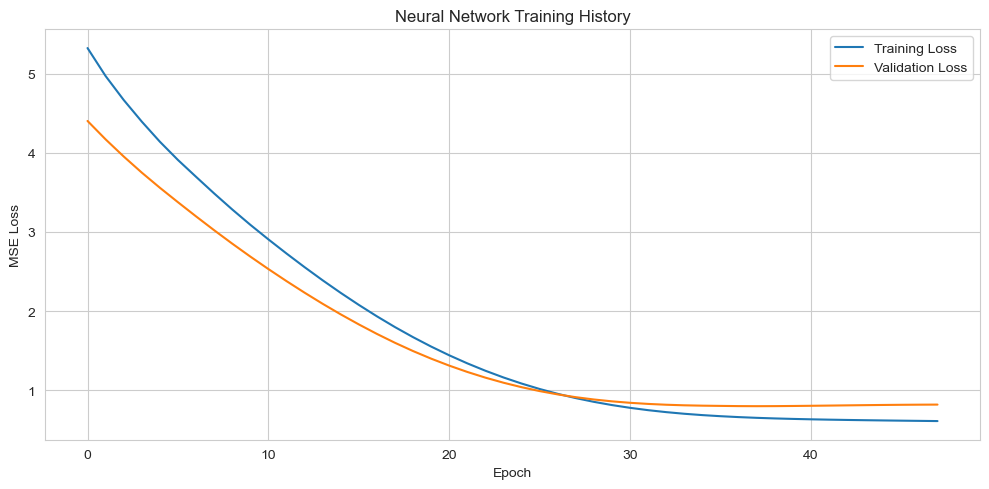

In [58]:
# -------------------------
# Visualize Training History
# -------------------------

plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Neural Network Training History')
plt.legend()
plt.tight_layout()
plt.show()
